<a href="https://colab.research.google.com/github/btho733/Belvin-Personal_Projects/blob/master/Project06_MONAIBootcamp/Workingcopy_lab1_transforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 1: Transforms

This lab will walk you through using MONAI transforms to setup a data pipeline for training.

First we'll import MONAI components:

In [1]:
%pip install -qU "monai[nibabel]==0.3.0rc2"

import tempfile
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

import monai
from monai.utils import first
from monai.data import Dataset, ArrayDataset, create_test_image_3d, DataLoader
from monai.transforms import (
    Transform,
    Randomizable,
    AddChannel,
    Compose,
    LoadNifti,
    Lambda,
    RandSpatialCrop,
    RandSpatialCropd,
    ToTensor,
)

     |████████████████████████████████| 296kB 2.8MB/s 


Next we'll create a temporary directory and populate it with a few example [Nifti file-format](https://nifti.nimh.nih.gov/) images containing a random assortment of spheres:

In [2]:
root_dir = tempfile.mkdtemp()
print(root_dir)
filenames = []

for i in range(5):
    im, _ = create_test_image_3d(256, 256, 256)

    filename = f"{root_dir}/im{i}.nii.gz"
    filenames.append(filename)

    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, filename)

/tmp/tmpu4kzsh33


## Array Transforms

Transforms in MONAI are callable objects accepting inputs from initial data in a dataset or previous transforms. We can create and call these directly without any infrastructure or system setup as components in MONAI are designed to be as decoupled as possible. For example we can load one of our Nifti files directly by creating the transform and calling it:

(256, 256, 256) /tmp/tmpu4kzsh33/im0.nii.gz


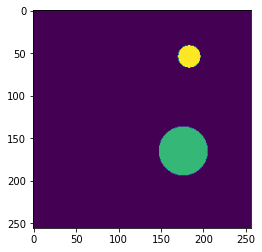

In [3]:
trans = LoadNifti()

img, header = trans(filenames[0])

print(img.shape, header["filename_or_obj"])
plt.imshow(img[128])

Transforms are composed with `Compose` to create a sequence of operations. `Compose` itself being a transform we can also call it directly:

In [4]:
trans = Compose([LoadNifti(image_only=True), AddChannel()])

img = trans(filenames[0])

print(img.shape)

(1, 256, 256, 256)


The type of `img` here is `numpy.ndarray` so to convert to a Pytorch tensor as part of a training data pipeline we'd have `ToTensor` as the last transform in our sequence:

In [5]:
trans = Compose([LoadNifti(image_only=True), AddChannel(), ToTensor()])

img = trans(filenames[0])

print(type(img), img.shape, img.get_device())

<class 'torch.Tensor'> torch.Size([1, 256, 256, 256]) -1


What device the tensor lives on is a matter to be addressed elsewhere in the training process.

We can define our own custom transform operation in a number of ways. If a simple callable is used as an operator, `Lambda` can be used to wrap it as a transform. We define in this example a transform to sum the image in the 1st (width) dimension to produce a 2D image:

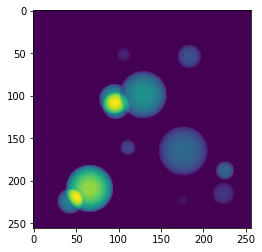

In [6]:
def sum_width(img):
    return img.sum(1)


trans = Compose([LoadNifti(image_only=True), AddChannel(), Lambda(sum_width)])

img = trans(filenames[0])

plt.imshow(img[0])

Creating a subclass of Transform is the second method, and this has the advantage of being able to define attributes with the instantiated objects. Let's define a class to sum in a chosen dimension, and use it to sum in the 2nd (height) dimension:

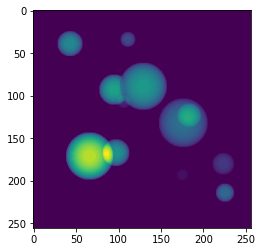

In [7]:
class SumDimension(Transform):
    def __init__(self, dim=1):
        self.dim = dim

    def __call__(self, inputs):
        return inputs.sum(self.dim)


trans = Compose([LoadNifti(image_only=True), AddChannel(), SumDimension(2)])

img = trans(filenames[0])

plt.imshow(img[0])

All of these example transforms so far have been deterministic, to define transforms which perform some stochastic operation on input data we want to also inherit from `Randomizable`. This class is used to randomize variables but also distinguish from deterministic transforms. We'll see why this is important later in caching data loaders. For now lets define a simple transform to add

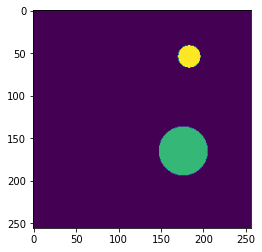

In [8]:
class RandAdditiveNoise(Randomizable, Transform):
    def __init__(self, prob: float = 0.5, max_add: float = 1.0) -> None:
        self.prob = np.clip(prob, 0.0, 1.0)
        self.max_add = max_add
        self._noise = 0

    def randomize(self, data: np.ndarray) -> None:
        self._noise = 0

        if self.R.random() < self.prob:
            noise_array = self.R.rand(*data.shape[1:])[None]
            self._noise = (noise_array * self.max_add).astype(data.dtype)

    def add_noise(self, img: np.ndarray) -> np.ndarray:
        return img + self._noise

    def __call__(self, img: np.ndarray) -> np.ndarray:
        self.randomize(img)
        return self.add_noise(img)


trans = Compose([LoadNifti(image_only=True), AddChannel(), RandAdditiveNoise()])

img = trans(filenames[0])

plt.imshow(img[0, 128])

Run this cell a few times to see the random transform being applied 50% of the time.

In this class we have a `numpy.random.RandomState` object to provide stochastic values. This can be replaced using `Randomizable.set_random_state()` to control the randomization process. The `randomize()` method is responsible for determining if the random operation is to be performed based on the `prob` probability member, then creates the random noise array if so. This functionality is in this method so that it can be called by `Compose` or other external controllers. 

## Dictionary Transforms

So far we have seen transforms which are applied to individual Numpy arrays, however for most training schemes a pipeline with multiple values is needed. To address this MONAI includes transforms for operating on dictionaries of arrays, one for each equivalent array transform. These can be applied to named values in an input dictionary while leaving unnamed values untouched, for example adding noise to an image while leaving the associated label image untouched. 

To demonstrate this we will repopulate our temporary directory with image/segmentation pairs and accumulate their names as a list of dictionaries:

In [9]:
fn_keys = ("img", "seg")  # filename keys for image and seg files
filenames = []

for i in range(5):
    im, seg = create_test_image_3d(256, 256, 256)

    im_filename = f"{root_dir}/im{i}.nii.gz"
    seg_filename = f"{root_dir}/seg{i}.nii.gz"

    filenames.append({"img": im_filename, "seg": seg_filename})

    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, im_filename)

    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, seg_filename)

We then import the dictionary equivalent transforms which have a `d` or `D` appended to their names:

In [10]:
from monai.transforms import (
    MapTransform,
    AddChanneld,
    LoadNiftid,
    Lambdad,
    ToTensord,
)

The `keys` argument in `LoadNiftid` is used to state which keys contain paths to Nifti files, all other values in the input dictionary will be retained. With this set we can look at the keys returned when calling the transform:

In [11]:
trans = LoadNiftid(keys=fn_keys)

data = trans(filenames[0])

print(list(data.keys()))

['img', 'seg', 'img_meta_dict', 'seg_meta_dict']


`Lambdad` applies the given callable to each array named by `keys` separately. We can use this to define transforms operating on different named values in the dictionary at different points in the sequence:

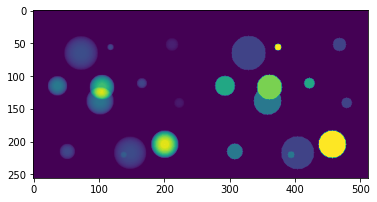

In [12]:
def sum_width(img):
    return img.sum(1)


def max_width(img):
    return img.max(1)


trans = Compose(
    [
        LoadNiftid(fn_keys),
        AddChanneld(fn_keys),
        Lambdad(("img",), sum_width),  # sum the image in the width dimension
        Lambdad(("seg",), max_width),  # take max label in the width dimension
    ]
)

imgd = trans(filenames[0])
img = imgd["img"]
seg = imgd["seg"]

plt.imshow(np.hstack((img[0] * 5 / img.max(), seg[0])))

The above applies one operation to one member of the dictionary and different operation to another. A reasonable re-implementation of this in one transform would require retaining the names of which members to apply which transform to and applying the operations in one method.

Adapting array-based transforms to operate over dictionaries is relatively straight-forward.

['img', 'seg', 'img_meta_dict', 'seg_meta_dict']


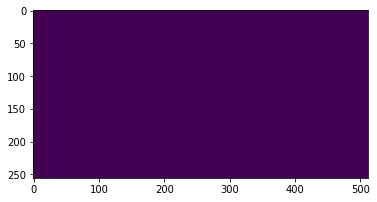

In [13]:
from monai.config import KeysCollection
from typing import Optional, Any, Mapping, Hashable


class RandAdditiveNoised(Randomizable, MapTransform):
    def __init__(
        self, keys: KeysCollection, prob: float = 0.5, max_add: float = 1.0
    ) -> None:
        super(Randomizable, self).__init__(keys)
        self.transform = RandAdditiveNoise(prob, max_add)

    def set_random_state(
        self, seed: Optional[int] = None, state: Optional[np.random.RandomState] = None
    ) -> "RandAdditiveNoised":
        self.transform.set_random_state(seed, state)
        super().set_random_state(seed, state)
        return self

    def randomize(self, data: Optional[Any] = None) -> None:
        self.transform.randomize(data)

    def __call__(
        self, data: Mapping[Hashable, np.ndarray]
    ) -> Mapping[Hashable, np.ndarray]:
        self.randomize(data[monai.utils.first(self.keys)])

        d = dict(data)
        for key in self.keys:
            d[key] = self.transform.add_noise(d[key])
        return d


trans = Compose(
    [LoadNiftid(fn_keys), AddChanneld(fn_keys), RandAdditiveNoised(("img",))]
)

img = trans(filenames[0])
print(list(img.keys()))

# note that we're adding random noise to the image alone, not the segmentation
plt.imshow(np.hstack([img["img"][0, 50], img["seg"][0, 50]]))

Method overrides are provided to delegate behaviour to an internal `RandAdditiveNoise` instance:
* `set_random_state` sets the state of the delegate and the current object
* `randomize` delegates the randomization to the `RandAdditiveNoise` instance
* `__call__` causes the delegate to randomize then applies the transform to each named member of the dictionary. The delegate transform is randomized only once, this ensures the same random field is added to each named member of the dictionary, a slightly different implementation adding a per-key random field would be needed if this were the desired behaviour. 

## Loading Datasets

With a data source and transforms defined we can now create a dataset object. The base class for MONAI is `Dataset`, created here to load the image Nifti files only:

In [14]:
images = [fn["img"] for fn in filenames]

transform = Compose([LoadNifti(image_only=True), AddChannel(), ToTensor()])

ds = Dataset(images, transform)

img_tensor = ds[0]

print(img_tensor.shape, img_tensor.get_device())

torch.Size([1, 256, 256, 256]) -1


`Dataset` inherits from the Pytorch class of that name and adds only the ability to apply the given transform to selected items. If you're familiar with the class from Pytorch this will work the same way. 

MONAI provides the `ArrayDataset` for supervised training applications specifically. It can accept data arrays for images separate from those for segmentations or labels with their own separate transforms. Here we will again separate out the image and segmentation filenames to demonstrate this usage:

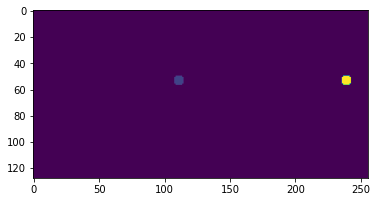

In [15]:
images = [fn["img"] for fn in filenames]
segs = [fn["seg"] for fn in filenames]

img_transform = Compose(
    [
        LoadNifti(image_only=True),
        AddChannel(),
        RandSpatialCrop((128, 128, 128), random_size=False),
        RandAdditiveNoise(),
        ToTensor(),
    ]
)

seg_transform = Compose(
    [
        LoadNifti(image_only=True),
        AddChannel(),
        RandSpatialCrop((128, 128, 128), random_size=False),
        ToTensor(),
    ]
)

ds = ArrayDataset(images, img_transform, segs, seg_transform)

im, seg = ds[0]

plt.imshow(np.hstack([im.numpy()[0, 48], seg.numpy()[0, 48]]))

Instead of returning a single image, accessing a member of the dataset produces a pair containing the image and segmentation after being pass through their respective transforms. One important aspect of this class is that the random state of each transform (`Compose` in this case) is set to that of the dataset before being applied. This ensures the same random operations are applied to each output, which is why the `RandSpatialCrop` operation chooses the same crop window for the image as well as the segmentation. By having separate transforms one can apply operations to images and not to segmentations (or vice versa), being careful that these unshared operations come after the shared ones.

Alternatively, `Dataset` can be used with dictionary-based transforms to construct a result mapping. For training applications beyond simple input/ground-truth pairs like the above this would be more suitable:

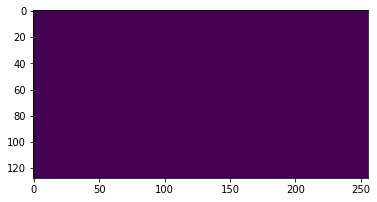

In [16]:
trans = Compose(
    [
        LoadNiftid(fn_keys),
        AddChanneld(fn_keys),
        RandAdditiveNoised(("img",)),
        RandSpatialCropd(fn_keys, (128, 128, 128), random_size=False),
        ToTensord(fn_keys),
    ]
)

ds = Dataset(filenames, trans)

item = ds[0]
im, seg = item["img"], item["seg"]

plt.imshow(np.hstack([im.numpy()[0, 48], seg.numpy()[0, 48]]))

With the dataset defined, we can now create the dataloader to create data batches. This inherits directly from Pytorch's `DataLoader` class with a few changes to the default constructor arguments. 

['img', 'seg', 'img_meta_dict', 'seg_meta_dict'] torch.Size([5, 1, 128, 128, 128])


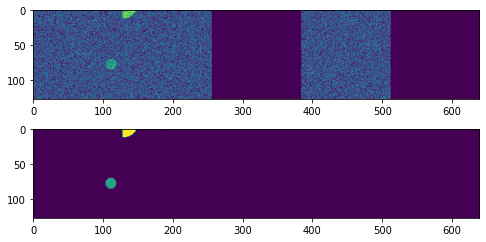

In [17]:
batch_size = 10

loader = DataLoader(ds, batch_size, num_workers=5)

batch = first(loader)

print(list(batch.keys()), batch["img"].shape)

f, ax = plt.subplots(2, 1, figsize=(8, 4))
ax[0].imshow(np.hstack(batch["img"][:, 0, 64]))
ax[1].imshow(np.hstack(batch["seg"][:, 0, 64]))

We now finally have a training batch together. The above `DataLoader` will use five worker processes to load the actual data. MONAI provides a number of `Dataset` subclasses to improve the efficiency of this process. These and other features will be covered in subsequent labs.